# Modules

In [1]:
#Basics
import sys
import os
import numpy as np
import pandas as pd

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm


# Specific to biomolecular simulations
import MDAnalysis as mda

# My functions
import functions as ki


/home/forget/software/anaconda3/envs/mdaenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/forget/software/anaconda3/envs/mdaenv2/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


# Charge Datas

In [4]:
# Load the data
myPath = "../Examples/"
myName = "A_HairpinRibozyme_REST2_traj"

df = pd.read_csv( myPath + myName + '.csv' )

In [29]:
Data_names = ['d_A-1:O2prime-G8:N1', 
              'd_A-1:O2prime-A10:N6', 
              'd_A-1:O2prime-A38:N6', 
              'd_A-1:O2prime-G+1:O1P', 
              'd_A-1:O2prime-G+1:O2P', 
              'd_G+1:O1P-G8:N2', 
              'd_G+1:O2P-G8:N2', 
              'A-1_puckering_pseudorot', 
              'IAA']

Long_names = ["A-1:O2' - G8:N1", 
             "A-1:O2' - A10:N6", 
             "A-1:O2' - A38:N6", 
             "A-1:O2'- G+1:pro-Sp", 
             "A-1:O2' - G+1:pro-Rp", 
             "G+1:pro-Sp - G8:N2", 
             "G+1:pro-Rp - G8:N2", 
             "A-1 pseudo-rotation (°)", 
             'IAA (°)']





# Generate Ordered H-Bonds


In [24]:
def fill_ColorIndexArray(dataArray, Data_namess):
    
    nl,nc=np.shape(dataArray)
    Emptyarray=np.zeros((nc,nl))
    
    for d in [0,1,2,3,4,5,6]:
        data=dataArray[d]
        for k in range(len(data)):
            if data[k]<=3.1 :
                Emptyarray[k,d]=1
            elif 3.1<data[k]<=4.1 :
                Emptyarray[k,d]=2
            elif 4.1<data[k]<=5.1 :
                Emptyarray[k,d]=3
    
    d=7
    pu = dataArray[d]
    for k in range(len(pu)):
        if 0<= pu[k] <= 36:
            Emptyarray[k,d]=4
        elif  144 <= pu[k] <= 180:
            Emptyarray[k,d]=5
    
    
    d=8
    IAA = dataArray[d]
    for k in range(len(IAA)):
        if 140 <= IAA[k] :
            #print(IAA[k],"k=",k,"d=",d)
            Emptyarray[k,d]=6
        elif 125 <= IAA[k] < 140:
            Emptyarray[k,d]=7
            
    return Emptyarray

In [25]:
def generate_CombinaisonsArray(Emptyarray):
    Saved_combinaisons=[]
    Combinaisons=[]
    nl,nc = np.shape(Emptyarray)
    for l in range(nl):
        combi = list(Emptyarray[l])
        if combi not in Saved_combinaisons:
           # print("Adding a new combinaison to already ",str(len(Saved_combinaisons)),"known",combi)
            Saved_combinaisons.append(combi)
            Combinaisons.append([combi,1,[l]])

        else:
            #print("searching for",combi," frame n"+str(l))
            flag =  False
            c = 0
            while flag == False:
                if combi == list(Combinaisons[c][0]):
                    #print("FOUND THE RIGHT COMBINAISON")
                    Combinaisons[c][1] += 1
                    Combinaisons[c][2].append(l)
                    flag = True
                else:
                    pass
                c+=1
    print("Finised and found",str(len(Saved_combinaisons)),"combinaisons")    
    Combinaisons2= np.asarray(Combinaisons, dtype="object")
    return Combinaisons2

In [26]:
def generateColored_df(df_plot, Data_names, nbOfFrames, cutoff=0.002):
    #### Fill the Array to plot ###
    ToFill = np.zeros(( nbOfFrames, len(Data_names)))
    Xaxes=[]
    origin = 0
    l = 0
    ratio = 1
    while ratio > cutoff: 
        count = df_plot.iloc[l,1]
        combi = df_plot.iloc[l,0]
        ratio = count/nbOfFrames
        #print(l,combi,count)
        Xaxes.append(origin)
        for b in range(len(combi)):
            for c in range(count):
                ToFill[origin + c,b]=combi[b]

        origin += count
        l+=1
        
    ColoredFP_df=pd.DataFrame(ToFill,columns = Long_names)
    ColoredFP_df_tr = ColoredFP_df.transpose()
    
    return ColoredFP_df_tr,Xaxes,l

In [27]:
def entropy_calculation(df_plot,total_samples):
    
    # Calculez les probabilités de chaque classe
    class_probabilities = []
    for l in range(len(Combinaisons)):
        count = df_plot.iloc[l,1]
        class_probabilities.append(count / total_samples)

    # Calculez l'entropie en utilisant la formule
    entropy = -sum(p * np.log2(p) for p in class_probabilities)

    print("L'entropie est :", entropy)
    return entropy

In [32]:

custom_colors = ['white','firebrick', 'lightcoral', 'mistyrose','lightsteelblue','navy','darkgoldenrod','tan']
custom_cmap = ListedColormap(custom_colors)

Selection=[11]
start_time = 300000 #ps
end_time = 0 #ps


    
time = df['Time']
print("Time of last frame = ",time[len(time)-1])
print("nb of frames=",len(time))
step = int(time[1])
print("size of step = ", time[0],time[1], str(float(time[len(time)-1])/len(time)))
start_frame = int(start_time/step)
print(str(start_frame), str(time[start_frame]),"ps", start_time)
if end_time != 0:
    end_frame = int(end_time/step)
else:
    end_frame = len(time) - 1
print("Ending frame : ", str(end_frame), str(time[end_frame]),"ps", end_time)

dataArray=[]
for d in range(len(Data_names)):
    data_values=df[Data_names[d]]
    print(len(data_values))
    dataArray.append(data_values[start_frame:end_frame])


print(dataArray[0:10])
Emptyarray = fill_ColorIndexArray(dataArray, Data_names)
nbOfFrames, nbdatas = np.shape(Emptyarray)
print(nbOfFrames)
#print("Emptyarray =",Emptyarray[0:100,8])
Combinaisons = generate_CombinaisonsArray(Emptyarray)

#print("Combinaisons =", Combinaisons)

df_plot = pd.DataFrame(np.array(Combinaisons), columns=['Indexes','Counts','Frames'])
entropy = entropy_calculation(df_plot, nbOfFrames)
df_plot = df_plot.sort_values('Counts',ascending=False)
ColoredFP_df_tr, Xaxes, K = generateColored_df(df_plot, Data_names, nbOfFrames, cutoff=0.005)
#print(ColoredFP_df_tr)

print(df_plot.shape)

f, ax = plt.subplots(figsize=(22,6))
mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))
custom_colors = ['white','firebrick', 'lightcoral', 'mistyrose','lightsteelblue','navy','darkgoldenrod','tan','b']
custom_cmap = ListedColormap(custom_colors)
cmap=sns.color_palette("cubehelix_r", as_cmap=True)
sns.heatmap(ColoredFP_df_tr, cmap=custom_cmap,vmin=0, vmax=8)
mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))

for ca in Xaxes:
    ax.axvline(x=ca,color='black')

# Ajouter un cadre en ajustant les limites des axes
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)



# Réglez les nouvelles étiquettes des xticks et leurs positions
ticks = []
labels = []
Showed=0
for t in range(1,K):
    ticks.append(((Xaxes[t]-Xaxes[t-1])/2 + Xaxes[t-1]) )
    labels.append(round((Xaxes[t]-Xaxes[t-1])/nbOfFrames*100,1) )
    print(t," ",round((Xaxes[t]-Xaxes[t-1])/nbOfFrames*100,1))
    Showed+=(Xaxes[t]-Xaxes[t-1])/nbOfFrames*100
print("Showed :", str(Showed),"%", "; Unshowed :", str(100-Showed),"%")
#ax.set_xticks(ticks)
#ax.set_xticklabels(labels, fontsize=18, rotation=45)
ax.set_xticks([])
ax.set_xticklabels([])

ax.tick_params(axis='y', labelsize= 28)  
    
x_axis_label_text = "%"  # Replace with your desired label text

# Set the x-axis label
ax.set_xlabel(x_axis_label_text, fontsize=28)

# Customize the rotation of the x-axis label if needed
ax.xaxis.set_label_coords(0.5, -0.15)  # Adjust the coordinates for positioning

#plt.savefig(Nextcloudpath+str(i)+"_ORDERED_Hbondfingerprint"+str(start_frame) +"-"+ str(end_frame)+".pdf", bbox_inches='tight')
plt.show()


Time of last frame =  672600.0
nb of frames= 13453
size of step =  0.0 50.0 49.99628335687207
6000 300000.0 ps 300000
Ending frame :  13452 672600.0 ps 0
13453
13453
13453
13453
13453
13453
13453
13453
13453
[6000     5.598959
6001     5.038773
6002     4.132517
6003     4.718506
6004     4.991923
           ...   
13447    2.947730
13448    4.451122
13449    4.755678
13450    4.694027
13451    4.405674
Name: d_A-1:O2prime-G8:N1, Length: 7452, dtype: float64, 6000     3.228544
6001     2.785142
6002     3.860166
6003     3.379038
6004     2.752565
           ...   
13447    7.158834
13448    3.052475
13449    3.043913
13450    2.806617
13451    2.768866
Name: d_A-1:O2prime-A10:N6, Length: 7452, dtype: float64, 6000     3.208269
6001     5.060835
6002     4.028427
6003     5.536541
6004     2.869392
           ...   
13447    8.665453
13448    2.924939
13449    2.854422
13450    2.883005
13451    3.254456
Name: d_A-1:O2prime-A38:N6, Length: 7452, dtype: float64, 6000     5.027860
6001  

KeyError: 0

['d_A-1:O2prime-G8:N1', 'd_A-1:O2prime-A10:N6', 'd_A-1:O2prime-A38:N6', 'd_A-1:O2prime-G+1:O1P', 'd_A-1:O2prime-G+1:O2P', 'd_G+1:O1P-G8:N2', 'd_G+1:O2P-G8:N2', 'A-1_puckering_pseudorot', 'IAA']
9


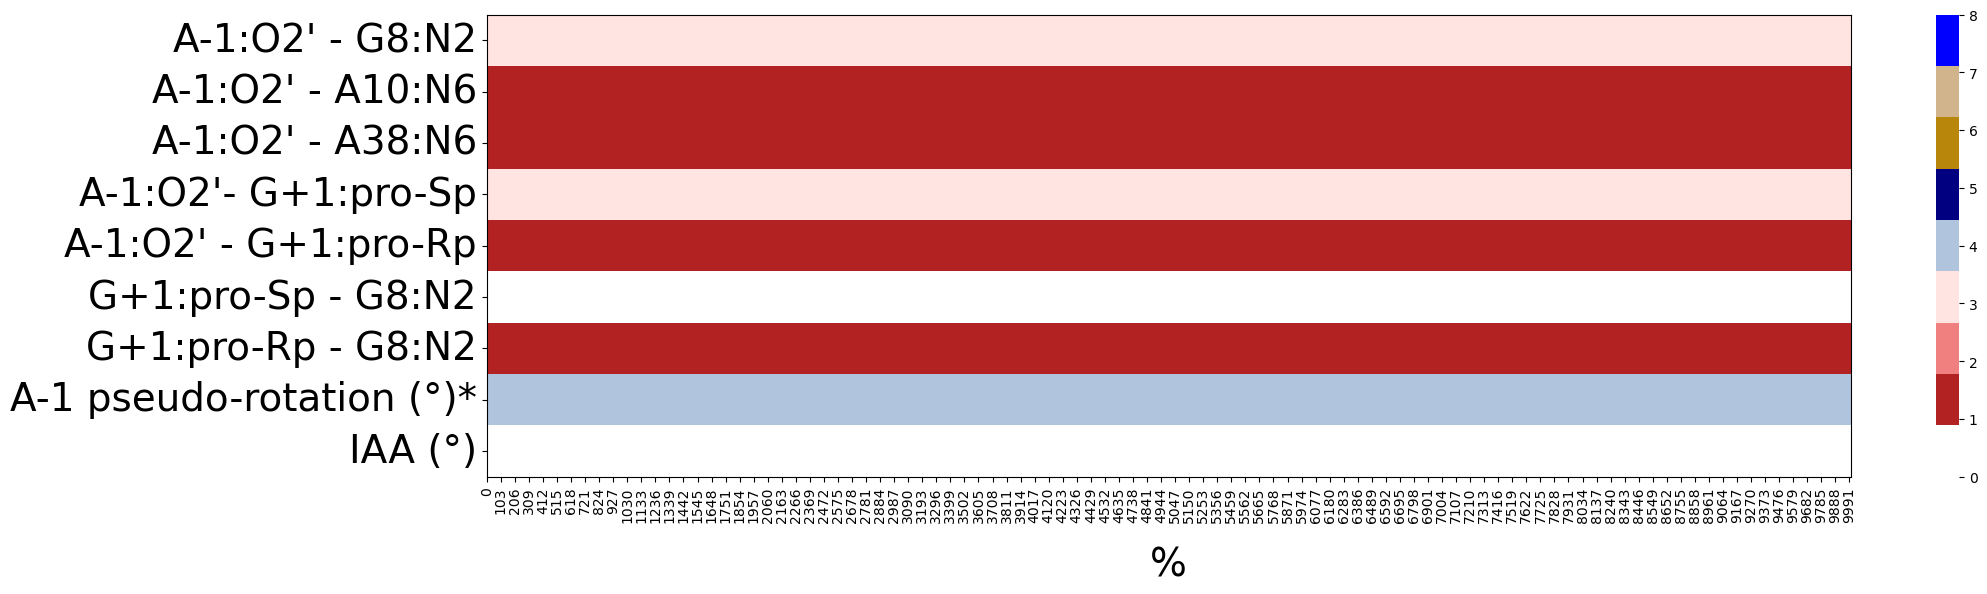

In [20]:
Shortnames = ['d1','d11','d10','d5','d6','d2','d2.2']
Data_names = [spe_hbonds_dic.get(s) for s in Shortnames]
Data_names.append('A-1_puckering_pseudorot')
Data_names.append('IAA')
Long_names = ["A-1:O2' - G8:N2", "A-1:O2' - A10:N6", "A-1:O2' - A38:N6", "A-1:O2'- G+1:pro-Sp", "A-1:O2' - G+1:pro-Rp", "G+1:pro-Sp - G8:N2", "G+1:pro-Rp - G8:N2","A-1 pseudo-rotation (°)*", 'IAA (°)']
print(Data_names)

custom_colors = ['white','firebrick', 'lightcoral', 'mistyrose','lightsteelblue','navy','darkgoldenrod','tan']
custom_cmap = ListedColormap(custom_colors)

configName = "Non-Aligned"
configuration = [3,1,1,3,1,0,1,4,0]
print(len(configuration))
nc = 9
nl = 10001 

Emptyarray=[]
for l in range(nl):
    Emptyarray.append(configuration)
Emptyarray=np.array(Emptyarray)

ColoredFP_df=pd.DataFrame(Emptyarray,columns = Long_names)
ColoredFP_df_tr = ColoredFP_df.transpose()

f, ax = plt.subplots(figsize=(22,6))
mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))
custom_colors = ['white','firebrick', 'lightcoral', 'mistyrose','lightsteelblue','navy','darkgoldenrod','tan','b']
custom_cmap = ListedColormap(custom_colors)
cmap=sns.color_palette("cubehelix_r", as_cmap=True)
sns.heatmap(ColoredFP_df_tr, cmap=custom_cmap,vmin=0, vmax=8)
mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))


# Ajouter un cadre en ajustant les limites des axes
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)


ax.tick_params(axis='y', labelsize= 28)  

x_axis_label_text = "%"  # Replace with your desired label text

# Set the x-axis label
ax.set_xlabel(x_axis_label_text, fontsize=28)

# Customize the rotation of the x-axis label if needed
ax.xaxis.set_label_coords(0.5, -0.15)  # Adjust the coordinates for positioning

plt.savefig(Nextcloudpath+configName+"_ORDERED_Hbondfingerprint.png")
plt.show()
    

In [ ]:
Emptyarray=np.zeros((nc,nl))
(10001, 9)
    
    for d in [0,1,2,3,4,5,6]:
        data=dataArray[d]
        for k in range(len(data)):
            if data[k]<=3.1 :
                Emptyarray[k,d]=1
            elif 3.1<data[k]<=4.1 :
                Emptyarray[k,d]=2
            elif 4.1<data[k]<=5.1 :
                Emptyarray[k,d]=3
    
    d=7
    pu = dataArray[d]
    for k in range(len(pu)):
        if 0<= pu[k] <= 36:
            Emptyarray[k,d]=4
        elif  144 <= pu[k] <= 180:
            Emptyarray[k,d]=5
    
    
    d=8
    IAA = dataArray[d]
    for k in range(len(IAA)):
        if 140 <= IAA[k] :
            #print(IAA[k],"k=",k,"d=",d)
            Emptyarray[k,d]=6
        elif 125 <= IAA[k] < 140:
            Emptyarray[k,d]=7
            
    return Emptyarray    
    exec('time='+df['Time'][0])
    nbOfFrames = len(time)
    print("Time of last frame = ",time[len(time)-1])
    print("nb of frames=",len(time))
    print("size of step = ", time[0],time[1], str(float(time[len(time)-1])/len(time)))

    #Emptyarray = fill_ColorIndexArray(dataArray, Data_names)
    #print("Emptyarray =",Emptyarray[0:100,8])
    Combinaisons = generate_CombinaisonsArray(Emptyarray)
    #print("Combinaisons =", Combinaisons)
    
    df_plot = pd.DataFrame(np.array(Combinaisons), columns=['Indexes','Counts','Frames'])
    df_plot = df_plot.sort_values('Counts',ascending=False)
    ColoredFP_df_tr, Xaxes = generateColored_df(df_plot, Data_names, len(time), cutoff=0.005)
    #print(ColoredFP_df_tr)

    f, ax = plt.subplots(figsize=(22,6))
    mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))
    custom_colors = ['white','firebrick', 'lightcoral', 'mistyrose','lightsteelblue','navy','darkgoldenrod','tan','b']
    custom_cmap = ListedColormap(custom_colors)
    cmap=sns.color_palette("cubehelix_r", as_cmap=True)
    sns.heatmap(ColoredFP_df_tr, cmap=custom_cmap,vmin=0, vmax=8)
    mask = np.triu(np.ones_like(ColoredFP_df_tr, dtype=bool))

    for ca in Xaxes:
        ax.axvline(x=ca,color='black')

    # Ajouter un cadre en ajustant les limites des axes
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)



    # Réglez les nouvelles étiquettes des xticks et leurs positions
    ticks = []
    labels = []
    for t in range(1,10):
        ticks.append(((Xaxes[t]-Xaxes[t-1])/2 + Xaxes[t-1]) )
        labels.append(round((Xaxes[t]-Xaxes[t-1])/nbOfFrames*100,1) )
        print(t," ",round((Xaxes[t]-Xaxes[t-1])/nbOfFrames*100,1))
    #ax.set_xticks(ticks)
    #ax.set_xticklabels(labels, fontsize=18, rotation=45)
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    ax.tick_params(axis='y', labelsize= 28)  
        
    x_axis_label_text = "%"  # Replace with your desired label text

    # Set the x-axis label
    ax.set_xlabel(x_axis_label_text, fontsize=28)

    # Customize the rotation of the x-axis label if needed
    ax.xaxis.set_label_coords(0.5, -0.15)  # Adjust the coordinates for positioning
    
    plt.savefig(Nextcloudpath+str(i)+"_ORDERED_Hbondfingerprint.png")
    plt.show()
    